# Compare TCW rasters with alternate method from CEWO


**What does this notebook do?**

**Required inputs**
* geotiffs of thresholded TCW extents
* geotiff of "off-river storages" identifed by cewo
* geotiff of cewo-identified extents

**Date** July 2018

Import some useful modules

In [4]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
#from datacube.storage import masking
import os
#sys.path.append('../Scripts/')
#import dea_spatialtools
import pandas as pd
import numpy as np


## Load in the repaired cewo file

In [36]:
# Open the GeoTIFFs using rasterio

In [5]:
test_fix = '/g/data/r78/rjd547/CEWO_Project/Macquarie_Marsh/bexnessresults/thresholded_wetness/clipped/cewo_20160628_extents_again.tif'

In [6]:
cewo_fix = xr.open_rasterio(test_fix)

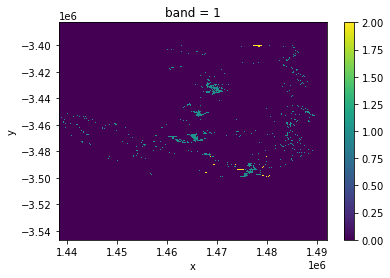

In [7]:
cewo_fix.plot()
plt.show()

In [9]:
cewo_fix = cewo_fix.squeeze()

build our comparison raster

In [10]:
#nodata values
cewo_fix2 =cewo_fix.where(cewo_fix!=65535.)
cewo_fix2=cewo_fix2.where(cewo_fix2!=-3.4028234663852886e+38)
cewo_fix2=cewo_fix2.where(cewo_fix2!=0)
cewo_fix2=cewo_fix2.where(cewo_fix2!=2)
cewoCount = cewo_fix2.count()
#cewoarea=numpy.round((cewoCount*25*25)/(1000*1000),2)
cewoarea=np.round((cewoCount*25*25)/(1000*1000),2)

In [11]:
#calculate area identified by RT aerial imagery
cewoarea

<xarray.DataArray ()>
array(99.27)
Coordinates:
    band     int64 1

In [12]:
cewo_fix2

<xarray.DataArray (y: 6564, x: 2144)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band     int64 1
  * y        (y) float64 -3.383e+06 -3.383e+06 ... -3.547e+06 -3.547e+06
  * x        (x) float64 1.438e+06 1.438e+06 1.438e+06 ... 1.492e+06 1.492e+06
Attributes:
    transform:      (25.0, 0.0, 1438421.0013571545, 0.0, -25.0, -3382788.8746...
    crs:            +init=epsg:3577
    res:            (25.0, 25.0)
    is_tiled:       0
    nodatavals:     (0.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

## Build the loop to load our rasters and calculate our %coverage

thresholds are our chosen thresholds for the TCW; these need to match the filenames, and are not set here.

In [13]:
thresholds = ['-0','-100','-200','-300','-400','-500','-600']

make a dataframe to fill with our results

In [14]:
comparison_df_pixels = pd.DataFrame(columns=['TCW','CEWO','both','%ofCEWO'],index=thresholds)
comparison_df_area = pd.DataFrame(columns=['TCW km^2','CEWO km^2','both km^2','%ofCEWO'],index=thresholds)

In [15]:
comparison_df_area

,TCW km^2,CEWO km^2,both km^2,%ofCEWO
-0,NaN,NaN,NaN,NaN
-100,NaN,NaN,NaN,NaN
-200,NaN,NaN,NaN,NaN
-300,NaN,NaN,NaN,NaN
-400,NaN,NaN,NaN,NaN
-500,NaN,NaN,NaN,NaN
-600,NaN,NaN,NaN,NaN


In [17]:
#make a list of the files corresponding to our set thresholds
thresholdFiles =[]
for i in range(0, len(thresholds)):
    thresholdFiles.append('/g/data/r78/rjd547/Macquarie_Marsh/bexnessresults/thresholded_wetness/clipped/t{0}_Mac_14_-35_20160627__20160629_clipped.tif'.format(thresholds[i]))
    #print (thresholdFiles[i])
    
    ThresholdData = xr.open_rasterio(thresholdFiles[i]) #thresholded TCW
    ThresholdData=ThresholdData.where(ThresholdData!=-3.4028234663852886e+38)
    ThresholdData=ThresholdData.where(ThresholdData!=0)
    ThresholdData=ThresholdData.where(cewo_fix.data!=2.0)
    thresholdCount=ThresholdData.where(ThresholdData==1.).count()
    #thresholdarea=numpy.round((thresholdCount*25*25)/(1000*1000),2)
    thresholdarea=np.round((thresholdCount*25*25)/(1000*1000),2)
    both = cewo_fix2.where(ThresholdData==1)
    bothCount = both.count()
    #botharea=numpy.round((thresholdCount*25*25)/(1000*1000),2)
    botharea=np.round((bothCount*25*25)/(1000*1000),2)
    comparison_df_pixels.loc[thresholds[i]]=[thresholdCount.data, cewoCount.data, bothCount.data, numpy.round(((bothCount/cewoCount)*100).data,decimals=2)]
    comparison_df_area.loc[thresholds[i]]=[thresholdarea.data, cewoarea.data, botharea.data, numpy.round(((botharea/cewoarea)*100).data,decimals=2)]
#     print(botharea)
#     plt.clf()
#     cewo_fix2.plot(cmap='Greens', vmin=0,vmax=1)
#     ThresholdData.plot(cmap='viridis',vmin=0,vmax=1)
#     both.plot(cmap='Wistia',vmin=0,vmax=1)
#     print('ready to save plots')
    
    %matplotlib inline
    plt.clf()
    fig = plt.figure(figsize=(10,11))
    ax=plt.gca()
    cewo_fix2.plot(cmap='Greens', vmin=0,vmax=1, alpha=0.7,add_colorbar=False)
    ThresholdData.plot(cmap='Greens',vmin=0,vmax=3,alpha=0.7,add_colorbar=False)
    both.plot(cmap='winter',vmin=0,vmax=1, alpha=0.7,add_colorbar=False)
    plt.title("TCW threshold "+thresholds[i])
    ax.set_ylim((-3500000, -3400000))
    print('ready to save plots')
    #plt.savefig('/g/data/r78/rjd547/Macquarie_Marsh/bexnessresults/plots/'+"3TCW_threshold_"+thresholds[i]+100321'.png')
    #plt.show()

RasterioIOError: /g/data/r78/rjd547/Macquarie_Marsh/bexnessresults/thresholded_wetness/clipped/t-0_Mac_14_-35_20160627__20160629_clipped.tif: No such file or directory

In [ ]:
%matplotlib inline
plt.clf()
fig = plt.figure(figsize=(10,11))
ax=plt.gca()
#ax.set_facecolor('xkcd:khaki')
cewo_fix2.isel(x=range(0, len(cewo_fix2.x),10), y=range(0, len(cewo_fix2.y),10)).plot(cmap='Greens', vmin=0,vmax=1, alpha=0.5,add_colorbar=False)
ThresholdData.isel(x=range(0, len(cewo_fix2.x),10), y=range(0, len(cewo_fix2.y),10)).plot(cmap='Greens',vmin=0,vmax=2,alpha=0.5,add_colorbar=False)
both.isel(x=range(0, len(cewo_fix2.x),10), y=range(0, len(cewo_fix2.y),10)).plot(cmap='winter',vmin=0,vmax=1, alpha=0.5,add_colorbar=False)
plt.title("TCW threshold "+thresholds[i])
ax.set_ylim((-3500000, -3400000))
plt.show()

In [ ]:
#write table to csv
plot.

In [ ]:
#comparison_df_pixels.to_csv('/g/data/r78/rjd547/Macquarie_Marsh/bexnessresults/Pixel_Comparison_Table.csv',)

In [ ]:
(91171/158833)*100

In [12]:
comparison_df_area

,TCW km^2,CEWO km^2,both km^2,%ofCEWO
-0,27.98,99.27,24.3,24.48
-100,38.41,99.27,32.15,32.39
-200,53.51,99.27,41.26,41.56
-300,76.94,99.27,49.64,50.01
-400,120.51,99.27,56.98,57.4
-500,201.18,99.27,63.73,64.2
-600,360.96,99.27,69.79,70.3


In [ ]:
#comparison_df_area.to_csv('/g/data/r78/rjd547/Macquarie_Marsh/bexnessresults/Area_Comparison_Table.csv',)

In [ ]:
# ThresholdData = xr.open_rasterio(thresholdFiles[0]) #thresholded TCW
#

In [ ]:
%matplotlib inline
plt.clf()
cewo_fix.plot(vmin=0, vmax=2, cmap='magma')
plt.show()

In [ ]:
# cewo_fix2 =cewo_fix.where(cewo_fix!=65535.)
# cewo_fix2=cewo_fix2.where(cewo_fix2!=-3.4028234663852886e+38)
# cewo_fix2=cewo_fix2.where(cewo_fix2!=0)
# cewo_fix2=cewo_fix2.where(cewo_fix2!=2)

In [ ]:
#cewo_fix2.isel(x=range(0, len(cewo_fix2.x),10), y=range(0, len(cewo_fix2.y),10)).plot()

In [ ]:
# cewoCount = cewo_fix2.count()

In [ ]:
both = cewo_fix2.where(ThresholdData==1)

In [ ]:
thresholdCount=ThresholdData.where(ThresholdData==1.).count()

In [ ]:
thresholdCount

In [ ]:
bothCount = both.count()

In [ ]:
plt.clf()
cewo_fix2.isel(x=range(0, len(cewo_fix2.x),10), y=range(0, len(cewo_fix2.y),10)).plot()
ThresholdData.isel(x=range(0, len(cewo_fix2.x),10), y=range(0, len(cewo_fix2.y),10)).plot(cmap='magma')
both.isel(x=range(0, len(cewo_fix2.x),10), y=range(0, len(cewo_fix2.y),10)).plot(cmap='Wistia')
plt.show()

In [ ]:
thresholds

In [ ]:
comparison_df = pd.DataFrame(columns=['TCW','CEWO','both','%ofCEWO'],index=thresholds)

In [ ]:
comparison_df.loc['-0']=[thresholdCount.data, cewoCount.data, bothCount.data, numpy.round(((bothCount/cewoCount)*100).data,decimals=2)]

In [ ]:
comparison_df

In [ ]:
## #filter out both sets of nodata values as defined by CEWO
# cewoData = cewoData.where(cewoData!=-3.4028234663852886e+38) #remove no data vals
# cewoData = cewoData.where(cewoData!=0) #remove no data vals
# cewoData = cewoData.where(cewoData!=65535.) #remove no data vals
# #cewoData = cewoData.where(cewoData!=2.) #remove off river storages

In [ ]:
plt.clf()
cewoData.plot()
plt.show()

In [ ]:
cewoData

In [ ]:
ThresholdData

In [ ]:
plt.clf()
ThresholdData.plot()
plt.show()

In [ ]:
# ThresholdData=ThresholdData.where(ThresholdData!=-3.4028234663852886e+38)
# ThresholdData=ThresholdData.where(ThresholdData!=0)
# ThresholdData=ThresholdData.where(cewoData.data!=2.0)

In [ ]:
ThresholdData

In [ ]:
#ThresholdData=ThresholdData.where(ThresholdData!=-3.4028234663852886e+38)
#ThresholdData=ThresholdData.where(ThresholdData!=0)
#ThresholdData=ThresholdData.where(cewoData.data!=2.0)

In [ ]:
plt.clf()
ThresholdData.plot()
plt.show()

In [ ]:
cewoData2=cewoData.where(cewoData!=65535.)
cewoData2 = cewoData2.where(cewoData2!=-3.4028234663852886e+38) #remove no data vals
cewoData2 = cewoData2.where(cewoData2!=0) #remove no data vals
cewoData2 = cewoData2.where(cewoData2.data!=2.0) #remove storages

In [ ]:
cewo_comp = cewo_comp.where(cewo_comp!=-3.4028234663852886e+38)
print(cewo_comp.count())
cewo_comp = cewo_comp.where(cewo_comp!=0)
print(cewo_comp.count())
cewo_comp = cewo_comp.where(cewo_comp!=65535.)
print(cewo_comp.count())
cewo_comp = cewo_comp.where(cewo_comp!=2.0)
print(cewo_comp.count())

In [ ]:
cewoData2.max()

In [ ]:
cewo_comp.size, ThresholdData.size

In [ ]:
print(cewo_comp.count(), ThresholdData.count())

In [ ]:
cewoData2.plot() 
plt.show()

In [ ]:
cewo

Shouldn't have to do this again but here is the reproject to template function, with intro

In [ ]:
# output = SpatialTools.reproject_to_template(cewo_compFile,thresholdFiles[0],'/g/data/r78/rjd547/Macquarie_Marsh/bexnessresults/thresholded_wetness/clipped/no_storages/cewo_20160628_test.tif')
# output = None

In [ ]:
# Make sure all the missing values are taken out
NDVIDatamaxNonull = NDVIDatamax.where(NDVIDatamax != -1)
NDMIDatamaxNonull = NDMIDatamax.where(NDMIDatamax != -1)

## Read in the validation mask and use it to examine the resulting pixel populations

In [ ]:
# Data * mask = data or nan
NDVIIrrigated = mask * NDVIDatamaxNonull
# Find where the mask is nan, and use this True/False to mask data
NDVINonIrrigated = NDVIDatamaxNonull.where(np.isnan(mask))

# Data * mask = data or nan
NDMIIrrigated = mask * NDMIDatamaxNonull
# Find where the mask is nan, and use this True/False to mask data
NDMINonIrrigated = NDMIDatamaxNonull.where(np.isnan(mask))

## Need to flatten the data so we can plot two single dimension arrays against each other

In [ ]:
NDVIIrrigatedflat = NDVIIrrigated.data.reshape(NDVIIrrigated.x.size * NDVIIrrigated.y.size)
NDVINonIrrigatedflat = NDVINonIrrigated.data.reshape(NDVINonIrrigated.x.size * NDVINonIrrigated.y.size)

NDMIIrrigatedflat = NDMIIrrigated.data.reshape(NDMIIrrigated.x.size * NDMIIrrigated.y.size)
NDMINonIrrigatedflat = NDMINonIrrigated.data.reshape(NDMINonIrrigated.x.size * NDMINonIrrigated.y.size)

## Draw a histogram of the two populations

Matplotlib histogram doesn't like `nan`, so we need to remove the `nan` values before we can create a histogram. This is done by reshaping the array into a single dimension, then removing the nan values.

This histogram will allow us to determine a valid threshold value for the automatic irrigated crop extent layer.

In [ ]:
bin_values = np.arange(0, 1.0, 0.02)

fig, axs = plt.subplots(1, 2, sharex=True, tight_layout=True, figsize = [9,5])
axs[0].hist(NDVIIrrigatedflat[np.isfinite(NDVIIrrigatedflat)], bins=bin_values, facecolor = 'blue');
axs[0].set_title('{0} for Namoi irrigated fields {0}'.format(Index, year))
axs[0].set_xlabel(Index)
axs[1].hist(NDVINonIrrigatedflat[np.isfinite(NDVINonIrrigatedflat)], bins=bin_values, facecolor = 'brown');
axs[1].set_title('{0} for Namoi non-irrigated fields {0}'.format(Index, year))
axs[1].set_xlabel(Index)
savefig('/g/data/r78/cek156/dea-notebooks/Crop_mapping/Playing_around/Namoi_NDVI_{1}.jpg'.format(Index, year))

## Is there a relationship between a pixel's NDVI and NDMI?

In [ ]:
plt.figure(figsize = [8,8])

plt.scatter(NDVINonIrrigatedflat[::10], NDMINonIrrigatedflat[::10], facecolor = 'brown', marker = '.')
plt.scatter(NDVIIrrigatedflat[::10], NDMIIrrigatedflat[::10], facecolor = 'blue', marker = '.')
plt.xlabel('NDVI')
plt.ylabel('NDMI')
plt.title('NDVI vs NDMI for every pixel in the Namoi Catchment')
plt.legend(['Non-irrigated pixels', 'Irrigated pixels'])
savefig('/g/data/r78/cek156/dea-notebooks/Crop_mapping/Playing_around/Namoi_scatter_{0}.jpg'.format(year))